In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [31]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


In [32]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

Load and Prepare data to input to LSTM model

In [33]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [34]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [35]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [36]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [37]:
train_set, test_set = splitData(data['Close'].values)

In [38]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [39]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [40]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [179]:
x_train_cluster, y_train_cluster = prepareDataForTraining(train_set)
x_test_cluster, y_test_cluster = prepareDataForTraining(test_set)

In [42]:
x_train_cluster = np.asarray(x_train_cluster).reshape(-1, window_size, 1)
y_train_cluster = np.asarray(y_train_cluster).reshape(-1, 1)
x_test_cluster = np.asarray(x_test_cluster).reshape(-1, window_size, 1)
y_test_cluster = np.asarray(y_test_cluster).reshape(-1, 1)

In [43]:
print('x_train_cluster.shape = ',x_train_cluster.shape)
print('y_train_cluster.shape = ',y_train_cluster.shape)
print('x_test_cluster.shape = ',x_test_cluster.shape)
print('y_test_cluster.shape = ',y_test_cluster.shape)

x_train_cluster = torch.from_numpy(x_train_cluster).type(torch.Tensor)
x_test_cluster = torch.from_numpy(x_test_cluster).type(torch.Tensor)
y_train_cluster = torch.from_numpy(y_train_cluster).type(torch.Tensor)
y_test_cluster = torch.from_numpy(y_test_cluster).type(torch.Tensor)

x_train_cluster.shape =  (2296, 20, 1)
y_train_cluster.shape =  (2296, 1)
x_test_cluster.shape =  (559, 20, 1)
y_test_cluster.shape =  (559, 1)


In [44]:
# This scales the timeseries into zero mean and unit variance. This is actually beneficial when multivariate timeseries clustering
# is done, beacause it is assumed that goal is to predict the shape of different timeseries than their amplitude.
# But for univariate timeseries, we are comparing different sections of the same timeseries, here the shape and amplitude both are important
# in order to understand what kinds of different trends exist, this is reflected through increasing or decreasing values.

scaler_clustering = TimeSeriesScalerMeanVariance()
x_train_cluster = scaler_clustering.fit_transform(x_train_cluster)

In [45]:
num_clusters = 5

In [46]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clusters,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=41)

#without normalization
# y_pred = dba_km.fit(x_train_cluster) : Only displays the cluster centres (in red) and the training data is not assigned to any cluster as 
# predict(train) is not done.

y_pred = dba_km.fit_predict(x_train_cluster)

DBA k-means


In [47]:
sz = x_train_cluster.shape[1]
sz

20

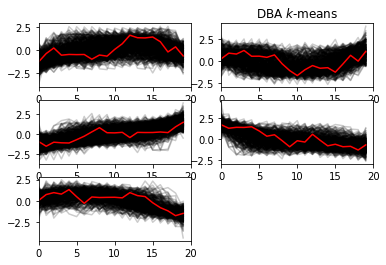

In [48]:
for yi in range(num_clusters):
    plt.subplot(3, 2, 1 + yi)
    for xx in x_train_cluster[y_pred == yi]:
        plt.plot(xx.flatten(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    # plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
    #          transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

(0.0, 20.0)

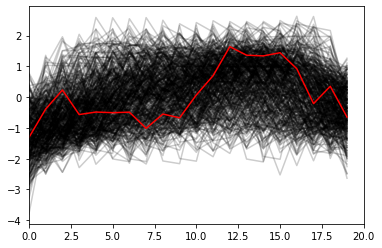

In [49]:
for xx in x_train_cluster[y_pred == 0]:    
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[0].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

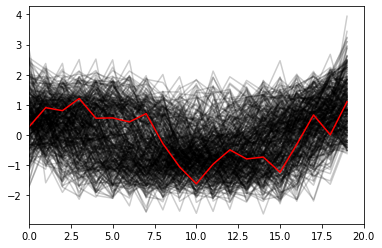

In [50]:
for xx in x_train_cluster[y_pred == 1]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[1].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

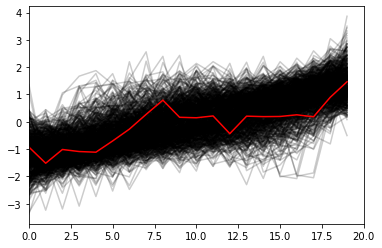

In [51]:
for xx in x_train_cluster[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

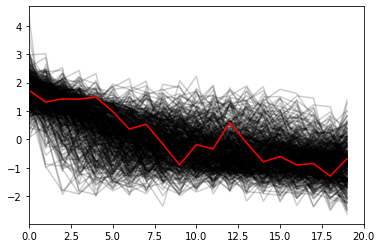

In [52]:
for xx in x_train_cluster[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

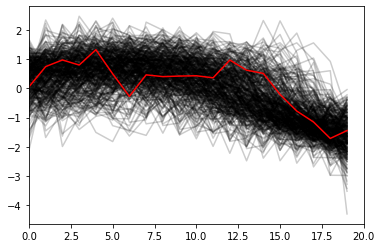

In [53]:
for xx in x_train_cluster[y_pred == 4]:    
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[4].ravel(), "r-")
plt.xlim(0, sz)

In [54]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster))
    

stats = pd.DataFrame({'mean': mean,
                    'standard deviation': std,
                    'variance': var

})

clusters = [i for i in range(num_clusters)]

stats.insert(0, 'clusters', clusters)
stats.set_index('clusters', inplace=True)


In [55]:
stats

,mean,standard deviation,variance
clusters,,,
0,0.062569,0.866840,0.751412
1,-0.011595,0.829708,0.688415
2,-0.104971,0.745676,0.556032
3,0.149686,0.946228,0.895348
4,0.153068,0.814329,0.663131


In [56]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [57]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [58]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.05 MAPE
R-squared value is 0.8690242379445693


#### Predict the cluster for test data

In [173]:
x_test_cluster = scaler_clustering.transform(x_test_cluster[300:400])

In [180]:
x_test_cluster_0 = scaler_clustering.transform(x_test_cluster[0:100])

In [175]:
res = dba_km.predict(x_test_cluster)

In [181]:
res0 = dba_km.predict(x_test_cluster_0)

In [177]:
res

array([2, 0, 0, 0, 1, 3, 3, 3, 0, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1])

In [182]:
res0

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 4, 3, 3, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 0, 4, 4, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

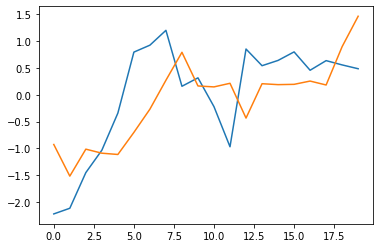

In [167]:
plt.plot(x_test_cluster[0])
plt.plot(dba_km.cluster_centers_[2])
# plt.plot(dba_km.cluster_centers_[0], 'g')
# plt.plot(dba_km.cluster_centers_[1], 'k')


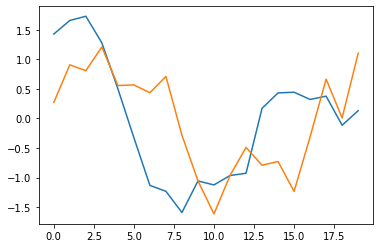

In [183]:
plt.plot(x_test_cluster_0[0])
plt.plot(dba_km.cluster_centers_[1])

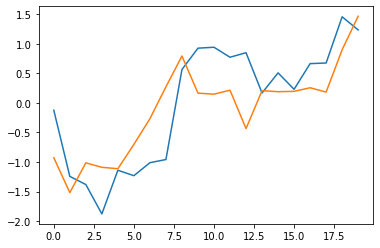

In [184]:
plt.plot(x_test_cluster_0[5])
plt.plot(dba_km.cluster_centers_[2])

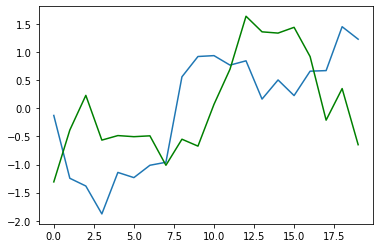

In [186]:
plt.plot(x_test_cluster_0[5])
plt.plot(dba_km.cluster_centers_[0], 'g')
# plt.plot(dba_km.cluster_centers_[1])
# plt.plot(dba_km.cluster_centers_[3])
# plt.plot(dba_km.cluster_centers_[4])

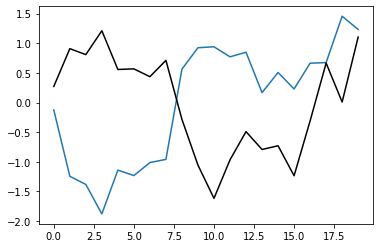

In [188]:
plt.plot(x_test_cluster_0[5])
plt.plot(dba_km.cluster_centers_[1], 'k')
# plt.plot(dba_km.cluster_centers_[3])
# plt.plot(dba_km.cluster_centers_[4])

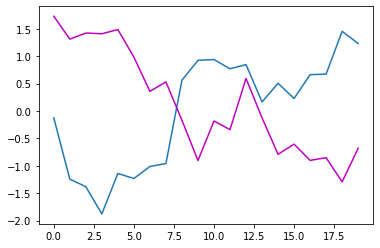

In [189]:
plt.plot(x_test_cluster_0[5])
plt.plot(dba_km.cluster_centers_[3], 'm')
# plt.plot(dba_km.cluster_centers_[4])

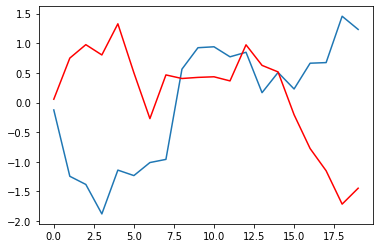

In [190]:
plt.plot(x_test_cluster_0[5])
plt.plot(dba_km.cluster_centers_[4], 'r')

In [140]:
x_test_sub = x_test[300:400]
x_test_sub.shape

torch.Size([100, 20, 1])

In [141]:
x_test_0 = scaler.inverse_transform(x_test_sub[0])
x_test_0

array([[1911.70001588],
       [1919.89998362],
       [1971.54999814],
       [2003.99997208],
       [2057.79999266],
       [2146.14994988],
       [2156.19995389],
       [2177.70001445],
       [2096.64999948],
       [2108.85000954],
       [2067.0999851 ],
       [2009.00001047],
       [2150.59997592],
       [2126.44999835],
       [2134.1000118 ],
       [2146.44997773],
       [2119.85002432],
       [2133.79998395],
       [2127.60000834],
       [2122.05001566]])

In [116]:
test = test_set[300:400]
test[0:20]

array([1911.7 , 1919.9 , 1971.55, 2004.  , 2057.8 , 2146.15, 2156.2 ,
       2177.7 , 2096.65, 2108.85, 2067.1 , 2009.  , 2150.6 , 2126.45,
       2134.1 , 2146.45, 2119.85, 2133.8 , 2127.6 , 2122.05])

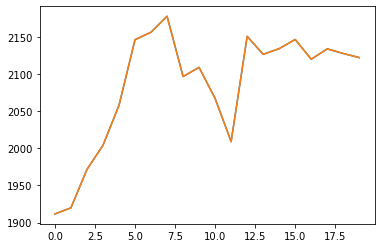

In [145]:
plt.plot(x_test_0)
plt.plot(test[0:20])

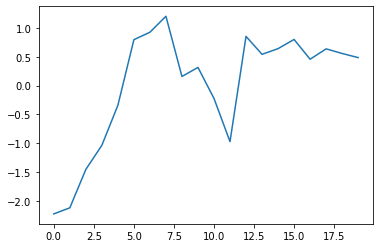

In [162]:
plt.plot(x_test_cluster[0])

In [157]:
test_0 = scaler_clustering.transform(x_test_0.reshape(-1,20))

In [158]:
x_test_cluster[0].shape, test_0.shape

((20, 1), (1, 20, 1))

In [159]:
test_0.flatten()

array([-2.22321473, -2.11763899, -1.45263776, -1.03483976, -0.3421569 ,
        0.79536128,  0.9247565 ,  1.20157282,  0.15804243,  0.31511928,
       -0.22241818, -0.97046356,  0.852656  ,  0.54172162,  0.64021663,
        0.79922418,  0.45674603,  0.63635373,  0.55652816,  0.48507122])

In [161]:
pd.DataFrame({'test 0': test_0.flatten(),
'cluster 0': x_test_cluster[0].flatten()}) 

,test 0,cluster 0
0,-2.223215,-2.223216
1,-2.117639,-2.117639
2,-1.452638,-1.452637
3,-1.034840,-1.034840
4,-0.342157,-0.342156
5,0.795361,0.795360
6,0.924757,0.924756
7,1.201573,1.201572
8,0.158042,0.158041
9,0.315119,0.315120


In [221]:
preds = y_test_pred[:,0]
test_gt = y_test[:, 0]

x_preds_cluster, y_preds_cluster = prepareDataForTraining(preds)
x_gt_cluster, y_gt_cluster = prepareDataForTraining(test_gt)



In [223]:
x_preds_cluster = np.asarray(x_preds_cluster).reshape(-1, 20, 1)
x_gt_cluster = np.asarray(x_gt_cluster).reshape(-1, 20, 1)

In [224]:
x_preds_cluster = scaler_clustering.transform(x_preds_cluster)
x_gt_cluster = scaler_clustering.transform(x_gt_cluster)

In [225]:
res_preds = dba_km.predict(x_preds_cluster)

In [226]:
res_gt = dba_km.predict(x_gt_cluster)

In [227]:
len(res_preds)

539

In [228]:
len(res_gt)

539

In [229]:
res_preds[264:284]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [230]:
res_gt[264:284]

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0])

In [231]:
res_preds[270:290]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 3, 3, 3])

In [232]:
res_gt[270:290]

array([2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 3, 3, 3, 0, 2])

In [233]:
res_preds[0:20]

array([4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 4, 4])

In [234]:
res_gt[0:20]

array([4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 4, 3, 3])

In [238]:
res_preds[135:138]

array([1, 1, 3])

In [237]:
res_gt[135:138]

array([3, 3, 3])

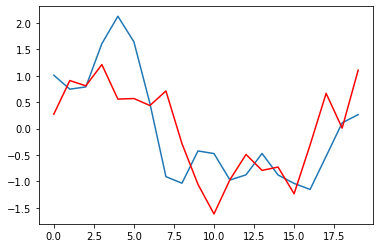

In [243]:
plt.plot(x_preds_cluster[135])
plt.plot(dba_km.cluster_centers_[1], 'r')

In [248]:
np.mean(x_preds_cluster[135]), np.std(x_preds_cluster[135]), np.var(x_preds_cluster[135])

(-1.865174681370263e-15, 1.0, 1.0)

In [249]:
np.mean(dba_km.cluster_centers_[1]), np.std(dba_km.cluster_centers_[1]), np.var(dba_km.cluster_centers_[1])

(-0.011595202920777004, 0.8297078261188824, 0.6884150767229216)

In [251]:
np.mean(dba_km.cluster_centers_[3]), np.std(dba_km.cluster_centers_[3]), np.var(dba_km.cluster_centers_[3])

(0.14968563791237371, 0.9462281720228021, 0.8953477535296136)

In [252]:
np.mean(x_gt_cluster[135]), np.std(x_gt_cluster[135]), np.var(x_gt_cluster[135])

(-1.6264767310758544e-15, 1.0, 1.0)

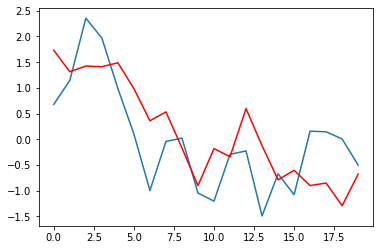

In [250]:
plt.plot(x_gt_cluster[135])
plt.plot(dba_km.cluster_centers_[3], 'r')